In [2]:
from platform import python_version

print(python_version())

3.7.4


In [3]:
import sys
# Add the path to system, local or mounted S3 bucket, e.g. /dbfs/mnt/<path_to_bucket>
sys.path.append('./secrets.py')

import logging
import math
import os

from influxdb import DataFrameClient
import numpy as np
import matplotlib.mlab as mlab
import pandas as pd
import matplotlib.pyplot as plt
from tabulate import tabulate
from tqdm import tqdm
%matplotlib inline

logging.basicConfig(level=logging.INFO)
LOGGER = logging.getLogger(__name__)

# Need to ssh tunnel for this to work
# ssh -L 8086:localhost:8086 aq.byu.edu -N
influx = DataFrameClient(
    host=HOST,
    port=PORT,
    username=USERNAME,
    password=PASSWORD,
    database=DATABASE,
)


def large_query(influx, measurement, query, total=None, limit=100_000):
    if total is not None:
        total = math.ceil(total / limit)

    with tqdm(total=total) as pbar:
        offset = 0
        while True:
            new_query = query + " LIMIT {} OFFSET {}".format(limit, offset)
            data = influx.query(new_query)
            data = data[measurement]

            received = len(data)
            pbar.update(1)

            yield data

            offset += limit
            if received != limit:
                break


def load_data(filename):
    if os.path.exists(filename):
        LOGGER.info("Loading cached data...")
        return pd.read_hdf(filename)

    LOGGER.info("Downloading data...")
    result = influx.query(
        "SELECT COUNT(sequence) FROM air_quality_sensor WHERE time > '2019-10-01' AND time <= now()"
    )
    count = result["air_quality_sensor"].values[0][0]

    queries = large_query(
        influx,
        "air_quality_sensor",
        "SELECT * FROM air_quality_sensor WHERE time > '2019-10-01' AND time <= now()",
        count,
    )

    all_data = pd.concat(list(queries), sort=False)
    all_data.to_hdf(filename, "data")
    return all_data


data = load_data("aq_data.h5")
gold_data = load_data("aq_data.h5")

LOGGER.info("Done loading data...")



INFO:__main__:Loading cached data...
INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:__main__:Loading cached data...
INFO:__main__:Done loading data...


2019-11-04 08:00:02+08:00
2019-11-04 08:00:02+08:00


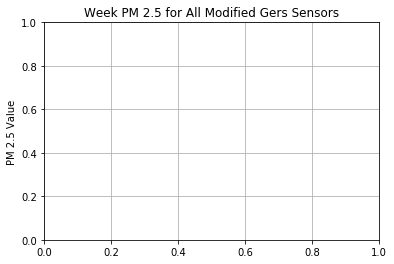

In [11]:
# all_modified_gers - This is the working boxplot for all_modified_gers only Mongolia deployed sensors
# https://stackoverflow.com/questions/22800079/converting-time-zone-pandas-dataframe
# https://pandas.pydata.org/pandas-docs/version/0.23.4/generated/pandas.DataFrame.between_time.html

# Don't include sensors: FL, IA, KS, MB, NB, NJ, NL, OR, WA, WY
# Look more closely at: NE, NS

from IPython.core.debugger import set_trace 
# https://matplotlib.org/3.1.3/gallery/statistics/boxplot_color.html 
print(data.index[1])
data.index = data.index.tz_convert('Asia/Ulaanbaatar')
print(data.index[1])

labels = ['All Modified Gers']
plt.xlabel('')
plt.ylabel('PM 2.5 Value')
plt.title('Week PM 2.5 for All Modified Gers Sensors')
plt.grid(True)
days = ['05', '06', '07', '08', '09', '10', '11']

# Clean up data this way:
data.loc[data['pm2_5'] > 1000, 'pm2_5'] = 1000
data.loc[data['pm2_5'] < 0, 'pm2_5'] = 0
# data['pm2_5'] = np.where(data['pm2_5'] >= 5000, 5000, data['pm2_5'])

data = data[data.location_name == 'Mongolia']

# start clean up data mode when in office or switched from outdoor to indoor or vice versa

# -------------------------- In Office ----------------------------------------------------------------------------------------------------------------------------
ak = data[data.index < '2020-02-15'].groupby("name").get_group('AK')
co = data[data.index < '2020-02-15'].groupby("name").get_group('CO')
ky = data[data.index < '2020-02-15'].groupby("name").get_group('KY')

# mb = data[data.index < '2020-02-15'].groupby("name").get_group('MB')
# mb = mb[(mb.index < '2020-01-26') | (mb.index >= '2020-02-04')]

# nj = data[(data.index < '2020-01-28') | (data.index >= '2020-02-04')].groupby("name").get_group('NJ')
nu = data[(data.index < '2020-01-26') | (data.index >= '2020-02-04')].groupby("name").get_group('NU')
# oregon = data[(data.index < '2020-01-26') | (data.index >= '2020-02-04')].groupby("name").get_group('OR')
pe = data[(data.index < '2020-02-11')].groupby("name").get_group('PE') #outdoor sensor we are no longer using these sensors data
# wy = data[(data.index < '2020-02-11')].groupby("name").get_group('WY') 

# --------------------------------------- Switched ---------------------------------------------------------------------------------------------------------------

ab = data[(data.index > '2020-01-28') & (data.index <= '2020-02-14')].groupby("name").get_group('AB') # outdoor sensor we are no longer using these sensors data before but will use after the switch to indoor
ns = data[(data.index >= '2020-01-28')].groupby("name").get_group('NS') # outdoor sensor we are no longer using these sensors data before but will use after the switch to indoor
# oregon = oregon[(oregon.index >= '2020-01-28')] # outdoor sensor we are no longer using these sensors data before but will use after the switch to indoor
ut = data[(data.index >= '2020-01-29')].groupby("name").get_group('UT') # outdoor sensor we are no longer using these sensors data before but will use after the switch to indoor

# finish clean up data mode when in office or switched from outdoor to indoor or vice versa
# ------------------------------------------------------------------------------------------------------------------------------------------------------

modified_gers = ['AL', 'AR', 'AZ', 'CA', 'CT', 'DE', 'ID', 'IL', 'LA', 'MA', 'MD', 'ME', 'MI', 'MN', 'MS', 'MT', 'NC', 'NH', 'NM', 'GA', 'ND', 'NE']
modified_gers_data = data[(data.name == modified_gers[0]) | (data.name == modified_gers[1]) | (data.name == modified_gers[2]) | (data.name == modified_gers[3]) | (data.name == modified_gers[4]) | (data.name == modified_gers[5]) | (data.name == modified_gers[6]) | (data.name == modified_gers[7]) | (data.name == modified_gers[8]) | (data.name == modified_gers[9]) | (data.name == modified_gers[10]) | (data.name == modified_gers[11]) | (data.name == modified_gers[12]) | (data.name == modified_gers[13]) | (data.name == modified_gers[14]) | (data.name == modified_gers[15]) | (data.name == modified_gers[16]) | (data.name == modified_gers[17]) | (data.name == modified_gers[18]) | (data.name == modified_gers[19]) | (data.name == modified_gers[20]) | (data.name == modified_gers[21])]
modified_gers_data = modified_gers_data.append(ak)
modified_gers_data = modified_gers_data.append(co)
modified_gers_data = modified_gers_data.append(ky)
# unmodified_gers = ['NJ', 'NS', 'NU', 'OK', 'OR', 'PA', 'RI', 'SD', 'UT', 'VA', 'WI']
# unmodified_gers_data = data[(data.name == unmodified_gers[0]) | (data.name == unmodified_gers[1]) | (data.name == unmodified_gers[2]) | (data.name == unmodified_gers[3]) | (data.name == unmodified_gers[4]) | (data.name == unmodified_gers[5]) | (data.name == unmodified_gers[6]) | (data.name == unmodified_gers[7]) | (data.name == unmodified_gers[8]) | (data.name == unmodified_gers[9]) | (data.name == unmodified_gers[10])]

unmodified_gers = ['OK', 'PA', 'RI', 'SD', 'VA', 'WI']
unmodified_gers_data = data[(data.name == unmodified_gers[0]) | (data.name == unmodified_gers[1]) | (data.name == unmodified_gers[2]) | (data.name == unmodified_gers[3]) | (data.name == unmodified_gers[4]) | (data.name == unmodified_gers[5])]
unmodified_gers_data = unmodified_gers_data.append(ab)
# unmodified_gers_data = unmodified_gers_data.append(mb)
# unmodified_gers_data = unmodified_gers_data.append(nj)
unmodified_gers_data = unmodified_gers_data.append(nu)
unmodified_gers_data = unmodified_gers_data.append(ns)
# unmodified_gers_data = unmodified_gers_data.append(oregon)
unmodified_gers_data = unmodified_gers_data.append(ut)


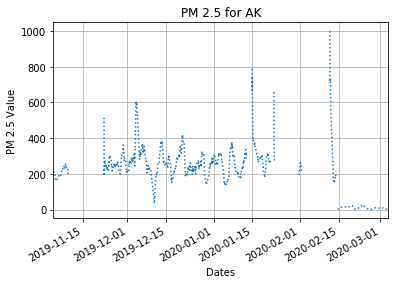

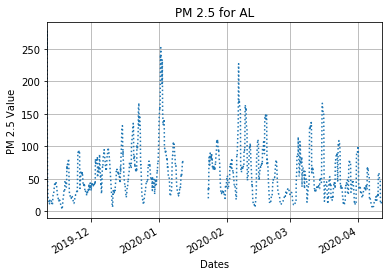

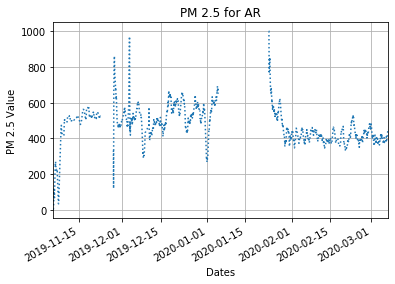

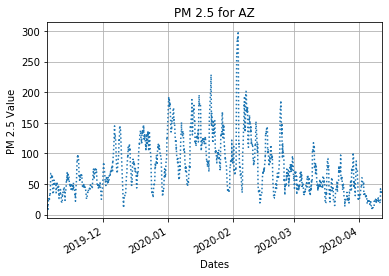

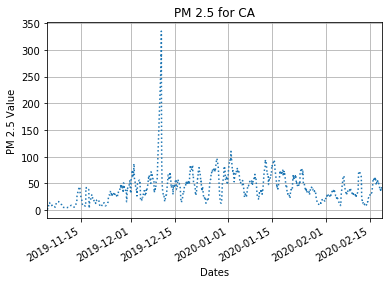

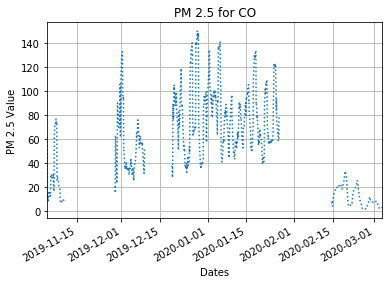

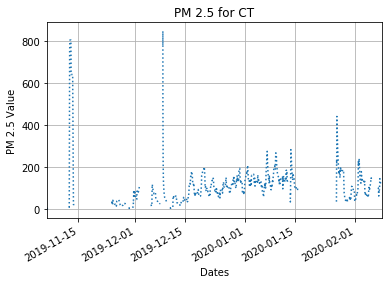

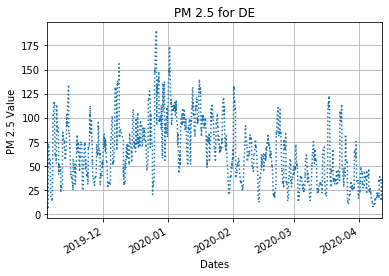

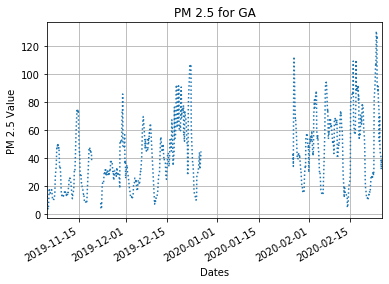

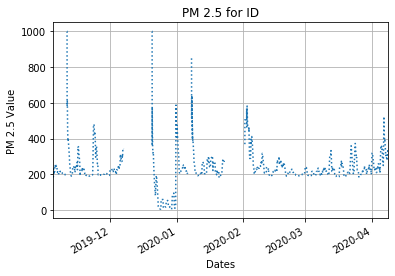

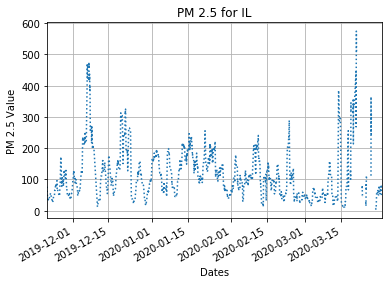

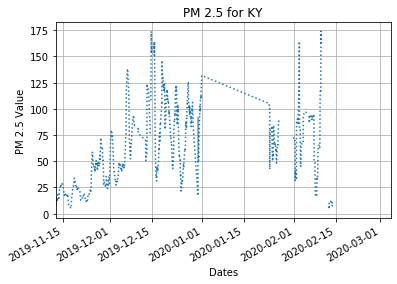

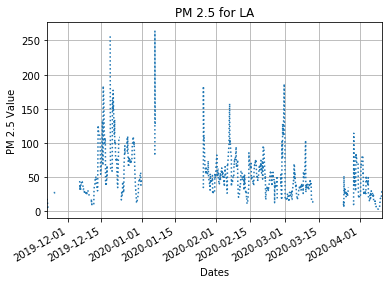

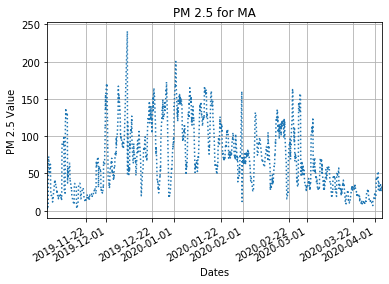

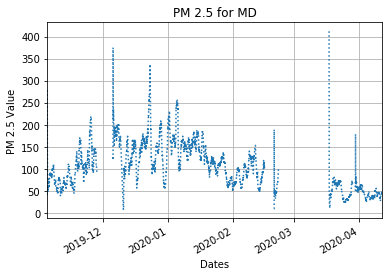

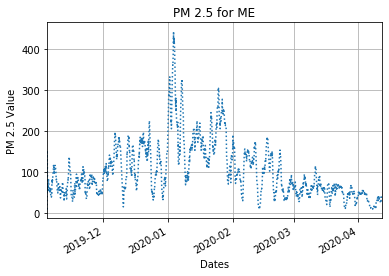

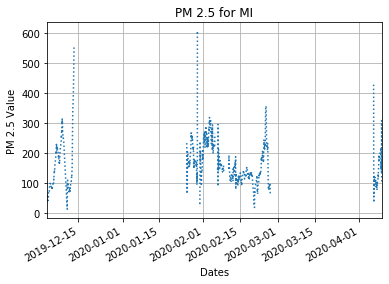

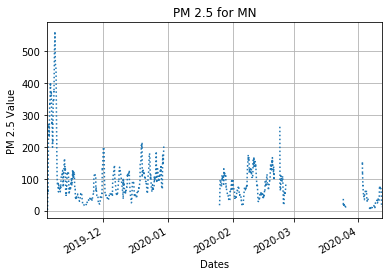

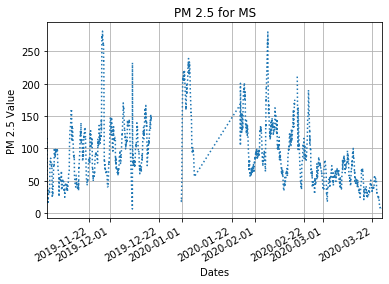

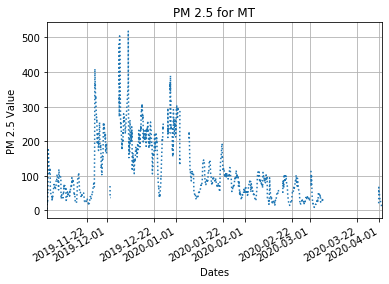

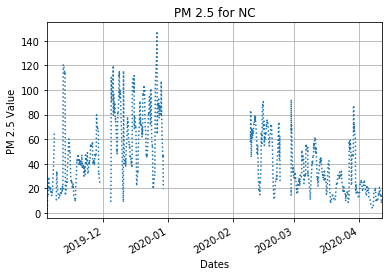

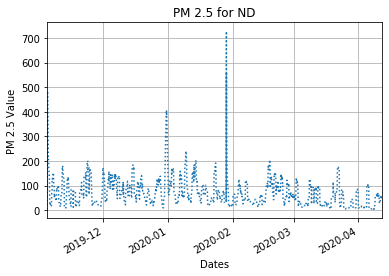

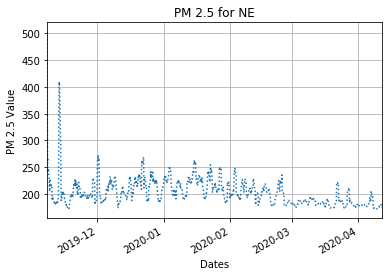

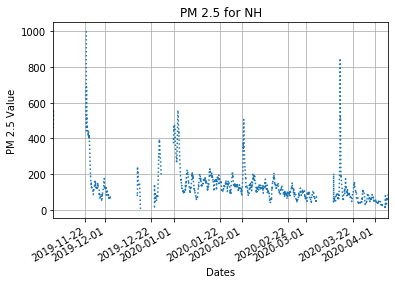

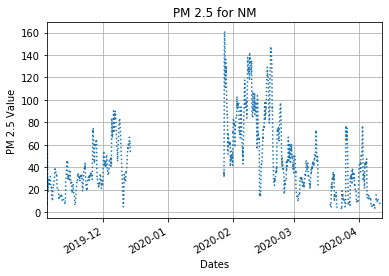

In [12]:
# this set is for daily PM 2.5 average for all modified gers
# https://stackoverflow.com/questions/36921951/truth-value-of-a-series-is-ambiguous-use-a-empty-a-bool-a-item-a-any-o

for name, sensor_data in modified_gers_data.groupby("name"):
    data.groupby("name").get_group(name)["pm2_5"].rolling("1d").mean().plot(lineStyle=':')
    plt.xlabel('Dates')
    plt.ylabel('PM 2.5 Value')
    plt.title('PM 2.5 for {}'.format(name))
    plt.grid(True)
    plt.show()
    
# data = gold_data

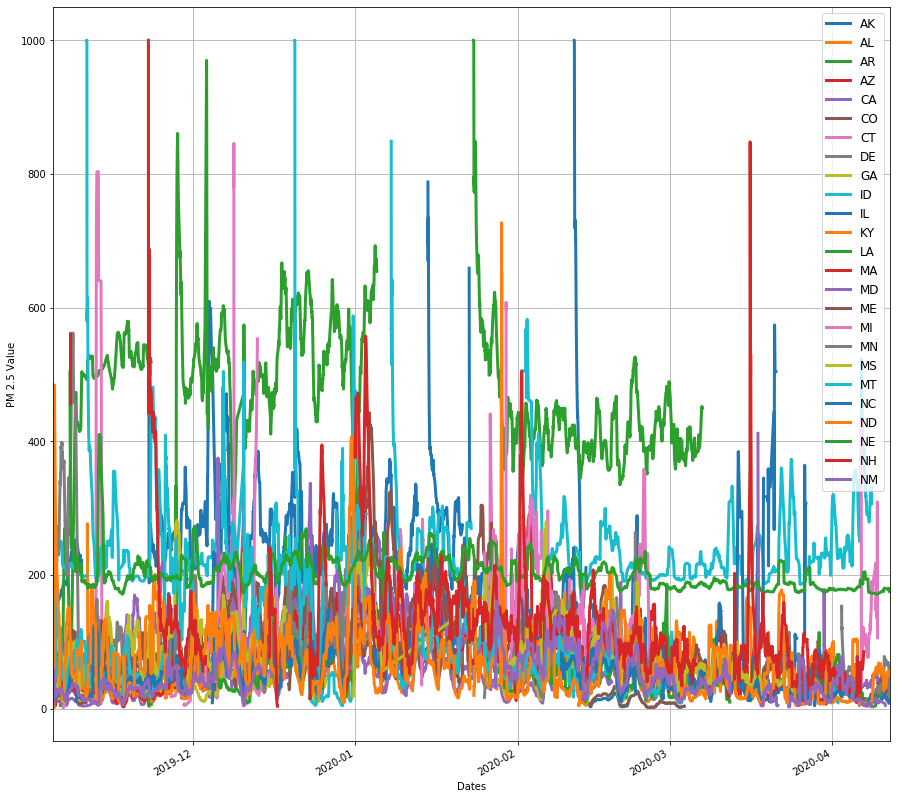

In [13]:
# this set is for daily PM 2.5 average for all unmodified gers
# https://stackoverflow.com/questions/36921951/truth-value-of-a-series-is-ambiguous-use-a-empty-a-bool-a-item-a-any-o

f, ax = plt.subplots(1)

# https://matplotlib.org/3.2.1/api/_as_gen/matplotlib.lines.Line2D.html#matplotlib.lines.Line2D.set_linestyle
for name, sensor_data in modified_gers_data.groupby("name"):
    data.groupby("name").get_group(name)["pm2_5"].rolling("1d").mean().plot(ax=ax, label=name, lineStyle='-', linewidth=3.0, figsize=(15, 15))
plt.xlabel('Dates')
plt.ylabel('PM 2.5 Value')
plt.grid(True)
plt.legend(loc='best', fontsize='large')
plt.show()  
    
# data = gold_data

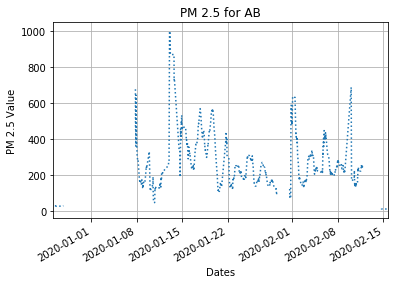

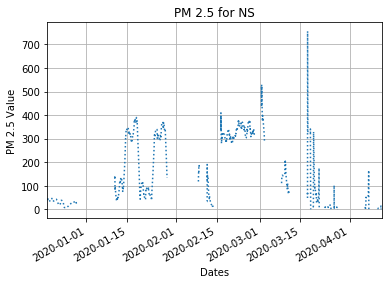

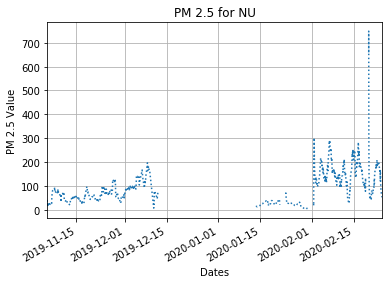

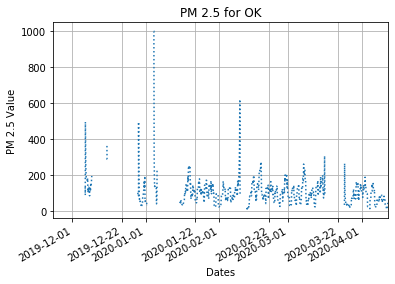

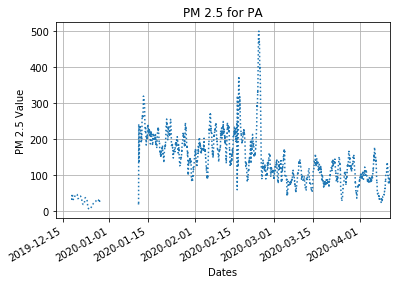

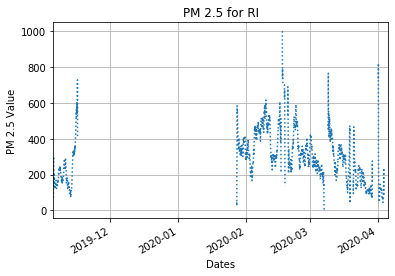

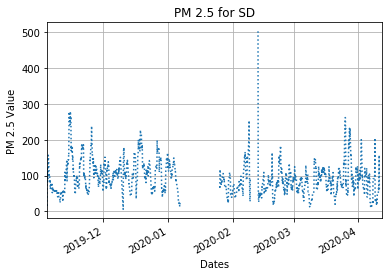

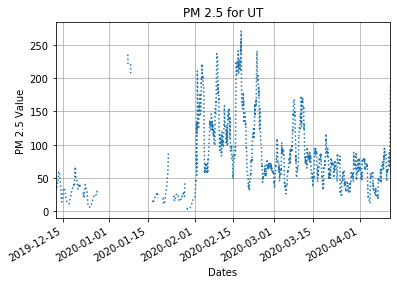

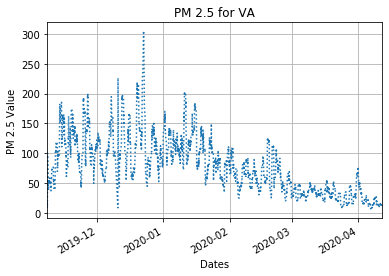

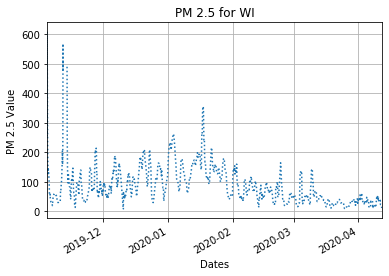

In [14]:
# this set is for daily PM 2.5 average for all unmodified gers
# https://stackoverflow.com/questions/36921951/truth-value-of-a-series-is-ambiguous-use-a-empty-a-bool-a-item-a-any-o

for name, sensor_data in unmodified_gers_data.groupby("name"):
    data.groupby("name").get_group(name)["pm2_5"].rolling("1d").mean().plot(lineStyle=':')
    plt.xlabel('Dates')
    plt.ylabel('PM 2.5 Value')
    plt.title('PM 2.5 for {}'.format(name))
    plt.grid(True)
    plt.show()
    
# data = gold_data

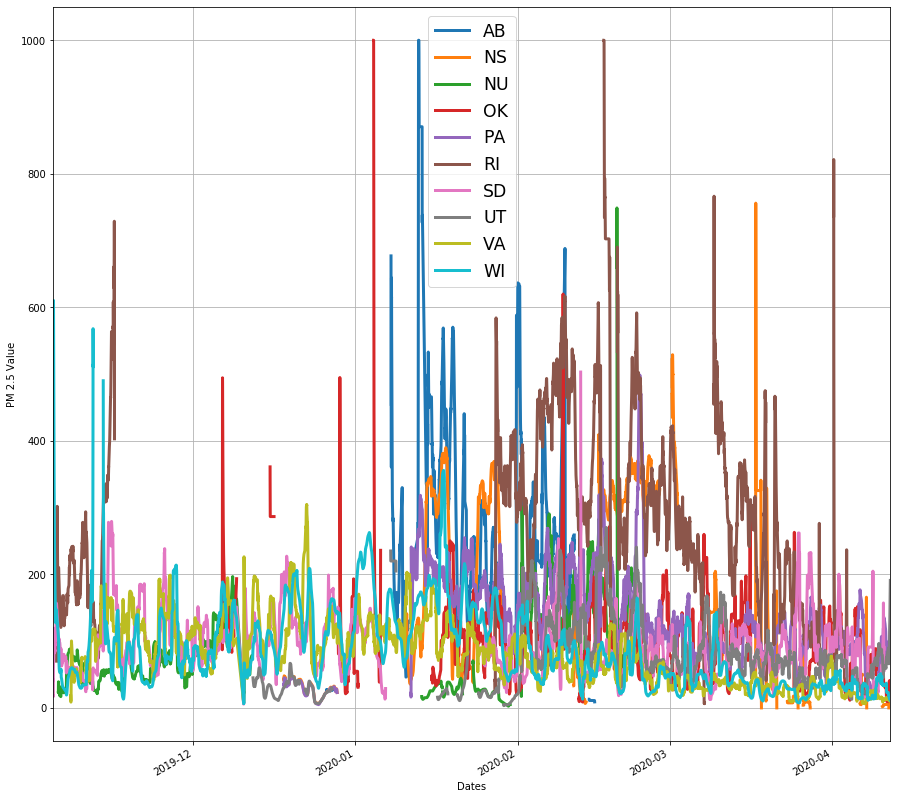

In [15]:
# this set is for daily PM 2.5 average for all unmodified gers
# https://stackoverflow.com/questions/36921951/truth-value-of-a-series-is-ambiguous-use-a-empty-a-bool-a-item-a-any-o

f, ax = plt.subplots(1)

# https://matplotlib.org/3.2.1/api/_as_gen/matplotlib.lines.Line2D.html#matplotlib.lines.Line2D.set_linestyle
for name, sensor_data in unmodified_gers_data.groupby("name"):
    data.groupby("name").get_group(name)["pm2_5"].rolling("1d").mean().plot(ax=ax, label=name, lineStyle='-', linewidth=3.0, figsize=(15, 15))
plt.xlabel('Dates')
plt.ylabel('PM 2.5 Value')
plt.grid(True)
plt.legend(loc='best', fontsize='xx-large')
plt.show()  
    
# data = gold_data